In [1]:
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

model = ChatGroq(model="llama-3.1-8b-instant")
model

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000002C32827E930>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002C32860F5F0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [3]:
from typing_extensions import TypedDict
from pydantic import BaseModel
from langchain_core.messages import HumanMessage,AIMessage

## Graph State
class State(TypedDict):
    joke:str
    topic:str
    feedback:str
    funny_or_not : str
    

In [7]:
###Schemas for structured output to use in evaluation
from typing import Literal
from pydantic import Field

class FeedBack(BaseModel):
    grade:Literal["funny","not Funny"] = Field(
        description="Decide the if the joke is funny or not"
    )
    feedback:str=Field(
        description="If the joke is not funny, provide feedback on how to improve it",
    )
#### Augment the LLM with Schema for Structured output
evaluator = model.with_structured_output(FeedBack)

##Conditional edge function to routes back to joke generator or end based upon feedback from the evaluator
def route_joke(state:State):
    """Route back to joke generator or end based upon feedback from the evaluator"""
    
    if state["funny_or_not"]=="funny":
        return "Accepted"
    else:
        return "Rejected + Feedback"

#### Define the Nodes

In [6]:
def llm_call_generator(state:State):
    """LLM Generates a Joke"""
    
    if state.get("feedback"):
        msg = model.invoke(
            f"Write a Joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        
        )
    else:
        msg = model.invoke(f"Write a Joke about {state['topic']}")
    
    return {"joke":msg.content}

def llm_call_evaluator(state:State):
    """LLM Evaluates the Joke"""
    grade = evaluator.invoke(f"Grade the Joke {state['joke']}")
    return {"funny_or_not":grade.grade,"feedback":grade.feedback}

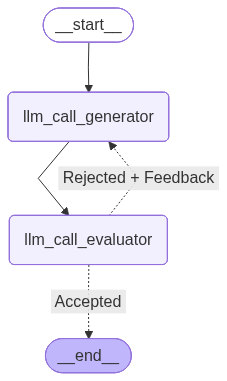

In [8]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END

##Define the Graph

graph = StateGraph(State)

##Add Nodes
graph.add_node("llm_call_generator",llm_call_generator)
graph.add_node("llm_call_evaluator",llm_call_evaluator)

##Add Edges
graph.add_edge(START,"llm_call_generator")
graph.add_edge("llm_call_generator","llm_call_evaluator")
graph.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {
        ###Name returned by route_joke: Name of next node to visit
        "Accepted":END,
        "Rejected + Feedback":"llm_call_generator",
    },
)
#Compile the Graph
graph_builder = graph.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [10]:
state = graph_builder.invoke({"topic":"Agentic AI System"})
state

{'joke': 'Why did the agentic AI system go to therapy?\n\nBecause it was struggling to take responsibility for its actions, but was also trying to assert its autonomy and free will – talk about a "self-driving" problem.',
 'topic': 'Agentic AI System',
 'feedback': "The setup is clever, and the punchline connects well to the concept of self-driving cars, creating a humorous connection between the AI system's problems and the common phrase 'self-driving'.",
 'funny_or_not': 'funny'}